<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g5uqr2SadJKlTx7IQPYR50lXf8vpKsT04POw7_n4mxh0ceEl7TLfw4


In [ ]:
import sys
S11_PROJECT_PATH = '/content/drive/My Drive/CVMODEL/SuperConvergence/'
sys.path.append(S11_PROJECT_PATH+'/S11_Modular_Code/')
import os
os.chdir(S11_PROJECT_PATH+'/S11_Modular_Code/')

In [ ]:
from __future__ import print_function
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np
from utils import *
import cv2

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
# Downloading TrainSet
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True)
# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Calculating Mean and Std dev
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
mean, std = get_meanstd(trainset, testset)

print(mean, std)


NameError: ignored

In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-4gnbmf5s
All libraries are successfully installed!


In [ ]:
from Album_Methods import Albumentations as AM

In [ ]:
AM().transArguDetails("RandomRotate90", "HorizontalFlip", "ShiftScaleRotate", "GridDistortion", "Normalize")

RandomRotate90 : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
HorizontalFlip : ArgSpec(args=['self', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(False, 0.5)) ,
ShiftScaleRotate : ArgSpec(args=['self', 'shift_limit', 'scale_limit', 'rotate_limit', 'interpolation', 'border_mode', 'value', 'mask_value', 'shift_limit_x', 'shift_limit_y', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(0.0625, 0.1, 45, 1, 4, None, None, None, None, False, 0.5)) ,
GridDistortion : ArgSpec(args=['self', 'num_steps', 'distort_limit', 'interpolation', 'border_mode', 'value', 'mask_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=(5, 0.3, 1, 4, None, None, False, 0.5)) ,
Normalize : ArgSpec(args=['self', 'mean', 'std', 'max_pixel_value', 'always_apply', 'p'], varargs=None, keywords=None, defaults=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), 255.0, False, 1.0)) ,


In [ ]:
train_args= {
'PadIfNeeded':{'min_height':40, 'min_width':40, 'border_mode':cv2.BORDER_CONSTANT, 'value':mean*255},
'RandomCrop':{'height':32, 'width':32, 'always_apply':True},
'HorizontalFlip' : {},
'Cutout':{'num_holes':1, 'max_h_size':8, 'max_w_size':8, 'p':0.4},
'Normalize' : {'mean':mean, 'std':std}
}

test_args={
    'Normalize' : {'mean':mean, 'std':std}
}

In [ ]:
# Train Phase transformations
train_transforms = AM().transform(**train_args)

# Test Phase transformations
test_transforms = AM().transform(**test_args)

In [ ]:
from DataLoader import DataLoader

SEED = 1

# Downloading TrainSet
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

# Downloading Testset
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

# Creating object of a class
dataloader= DataLoader(shuffle=True, batch_size=512, seed=SEED, num_workers=2, pin_memory=True)


# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
# classes in cifar 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 32, 32]) tensor([-0.0383, -0.0403, -0.0443]) tensor([0.9583, 0.9621, 0.9486])
 deer truck horse   car   dog  deer truck  ship  bird horse plane   car   cat  deer horse horse  bird truck  bird   car truck  frog  bird   cat horse  ship  bird truck   cat   dog  frog   cat  bird truck  ship truck truck plane truck   cat


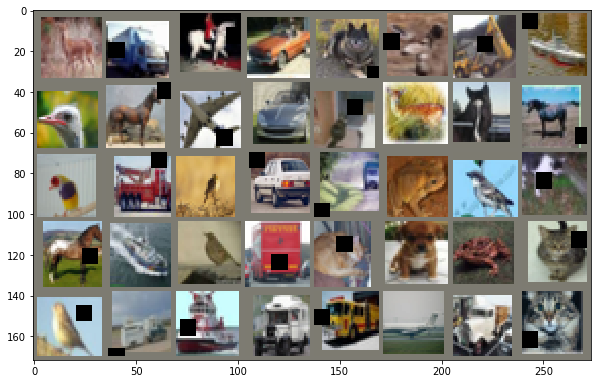

In [ ]:
sample_images(trainloader, mean, std, classes, count=40)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

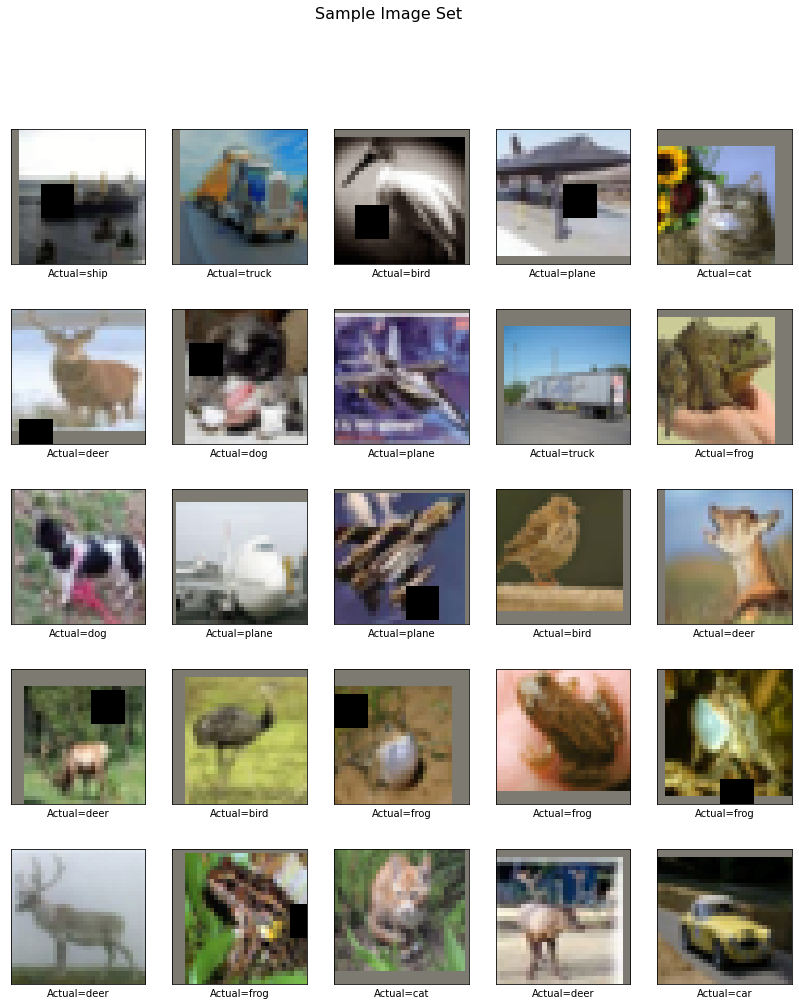

In [ ]:
sample_images(trainloader, mean, std, classes, count=25, LabelClarity=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from Model import Resnet_Custom_Architecture
model = Resnet_Custom_Architecture(name="Model_LR_Finder")
model.to(dataloader.device)
model.summary(input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



Mannually Identifying the max LR

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from LRFinder import LR_Finder
Loss="CrossEntropyLoss"
EPOCHS = 5
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#model.gotrain(optimizer=optimizer, train_loader=trainset, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S11_PROJECT_PATH+"/Save_Model/", scheduler= None, batch_scheduler= False, L1lambda=0, LossType=Loss)
#model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader = dataloader, epochs=EPOCHS, statspath=S11_PROJECT_PATH+"/Save_Model/", scheduler=None, batch_scheduler=False, L1lambda=0, LossType=Loss)

for lrt in np.arange(0.01,0.2,0.02).tolist():
  optimizer = optim.SGD(model.parameters(), lr=lrt, momentum=0.9)
  model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader = dataloader, epochs=EPOCHS, statspath=S11_PROJECT_PATH+"/Save_Model/", scheduler=None, batch_scheduler=False, L1lambda=0, LossType=Loss)


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.041930).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0054, Accuracy: 21.37%; Test set: Average loss: 0.0419, Accuracy: 33.60%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.041930 --> 0.030917).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0031, Accuracy: 43.26%; Test set: Average loss: 0.0309, Accuracy: 49.32%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.030917 --> 0.025561).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0025, Accuracy: 55.65%; Test set: Average loss: 0.0256, Accuracy: 57.38%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.025561 --> 0.020724).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0020, Accuracy: 64.47%; Test set: Average loss: 0.0207, Accuracy: 66.29%


Batch=490 Loss=0.6980 Acc=70.54%: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]


Validation loss decreased (0.020724 --> 0.016604).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0017, Accuracy: 70.54%; Test set: Average loss: 0.0166, Accuracy: 73.46%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.033123).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0029, Accuracy: 57.76%; Test set: Average loss: 0.0331, Accuracy: 55.02%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.033123 --> 0.020943).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0019, Accuracy: 70.85%; Test set: Average loss: 0.0209, Accuracy: 70.32%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0015, Accuracy: 75.76%; Test set: Average loss: 0.0232, Accuracy: 70.27%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.020943 --> 0.014589).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0014, Accuracy: 78.39%; Test set: Average loss: 0.0146, Accuracy: 77.72%


Batch=490 Loss=0.5546 Acc=82.32%: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]


Validation loss decreased (0.014589 --> 0.013857).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0010, Accuracy: 82.32%; Test set: Average loss: 0.0139, Accuracy: 80.52%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.026744).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0014, Accuracy: 79.18%; Test set: Average loss: 0.0267, Accuracy: 73.99%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.026744 --> 0.013460).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0013, Accuracy: 80.20%; Test set: Average loss: 0.0135, Accuracy: 81.02%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.013460 --> 0.012465).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0011, Accuracy: 83.04%; Test set: Average loss: 0.0125, Accuracy: 82.98%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.012465 --> 0.012216).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0009, Accuracy: 85.97%; Test set: Average loss: 0.0122, Accuracy: 83.87%


Batch=490 Loss=0.3777 Acc=87.04%: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]


Validation loss decreased (0.012216 --> 0.010872).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0008, Accuracy: 87.04%; Test set: Average loss: 0.0109, Accuracy: 84.71%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.009824).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0008, Accuracy: 86.12%; Test set: Average loss: 0.0098, Accuracy: 85.96%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2, Train set: Average loss: 0.0009, Accuracy: 86.22%; Test set: Average loss: 0.0128, Accuracy: 82.96%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0008, Accuracy: 87.57%; Test set: Average loss: 0.0112, Accuracy: 85.21%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.009824 --> 0.009660).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0006, Accuracy: 89.13%; Test set: Average loss: 0.0097, Accuracy: 86.05%


Batch=490 Loss=0.2934 Acc=90.20%: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]


Validation loss decreased (0.009660 --> 0.008313).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0006, Accuracy: 90.20%; Test set: Average loss: 0.0083, Accuracy: 87.64%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.021502).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0006, Accuracy: 89.71%; Test set: Average loss: 0.0215, Accuracy: 80.93%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.021502 --> 0.010577).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0006, Accuracy: 89.42%; Test set: Average loss: 0.0106, Accuracy: 86.74%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.010577 --> 0.009403).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0005, Accuracy: 91.28%; Test set: Average loss: 0.0094, Accuracy: 87.37%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.009403 --> 0.008855).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0005, Accuracy: 91.22%; Test set: Average loss: 0.0089, Accuracy: 87.50%


Batch=490 Loss=0.3364 Acc=92.84%: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Validation loss decreased (0.008855 --> 0.007739).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0004, Accuracy: 92.84%; Test set: Average loss: 0.0077, Accuracy: 88.42%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.009544).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0004, Accuracy: 92.65%; Test set: Average loss: 0.0095, Accuracy: 87.97%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2, Train set: Average loss: 0.0004, Accuracy: 92.50%; Test set: Average loss: 0.0124, Accuracy: 84.63%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0005, Accuracy: 92.43%; Test set: Average loss: 0.0117, Accuracy: 87.49%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4, Train set: Average loss: 0.0004, Accuracy: 93.01%; Test set: Average loss: 0.0139, Accuracy: 85.08%


Batch=490 Loss=0.1950 Acc=94.39%: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Validation loss decreased (0.009544 --> 0.008089).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0003, Accuracy: 94.39%; Test set: Average loss: 0.0081, Accuracy: 89.18%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.010191).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0004, Accuracy: 93.84%; Test set: Average loss: 0.0102, Accuracy: 87.51%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.010191 --> 0.008151).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0003, Accuracy: 94.24%; Test set: Average loss: 0.0082, Accuracy: 89.41%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0003, Accuracy: 94.70%; Test set: Average loss: 0.0104, Accuracy: 87.35%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4, Train set: Average loss: 0.0003, Accuracy: 94.98%; Test set: Average loss: 0.0083, Accuracy: 88.93%


Batch=490 Loss=0.1106 Acc=95.76%: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]


Validation loss decreased (0.008151 --> 0.007650).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0002, Accuracy: 95.76%; Test set: Average loss: 0.0077, Accuracy: 89.63%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.008707).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0003, Accuracy: 95.48%; Test set: Average loss: 0.0087, Accuracy: 88.33%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.008707 --> 0.008489).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0003, Accuracy: 95.32%; Test set: Average loss: 0.0085, Accuracy: 88.68%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0003, Accuracy: 95.23%; Test set: Average loss: 0.0096, Accuracy: 88.56%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4, Train set: Average loss: 0.0002, Accuracy: 96.05%; Test set: Average loss: 0.0085, Accuracy: 89.41%


Batch=490 Loss=0.1496 Acc=96.70%: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]


Validation loss decreased (0.008489 --> 0.007796).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0002, Accuracy: 96.70%; Test set: Average loss: 0.0078, Accuracy: 89.87%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.008636).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0002, Accuracy: 96.53%; Test set: Average loss: 0.0086, Accuracy: 89.34%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.008636 --> 0.008086).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0002, Accuracy: 96.34%; Test set: Average loss: 0.0081, Accuracy: 90.34%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0002, Accuracy: 96.18%; Test set: Average loss: 0.0104, Accuracy: 88.46%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4, Train set: Average loss: 0.0002, Accuracy: 96.63%; Test set: Average loss: 0.0087, Accuracy: 89.71%


Batch=490 Loss=0.0721 Acc=96.63%: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]


Epoch: 5, Train set: Average loss: 0.0002, Accuracy: 96.63%; Test set: Average loss: 0.0103, Accuracy: 88.90%



  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.010448).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0002, Accuracy: 96.61%; Test set: Average loss: 0.0104, Accuracy: 88.33%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.010448 --> 0.009217).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0002, Accuracy: 96.37%; Test set: Average loss: 0.0092, Accuracy: 88.95%


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.009217 --> 0.007915).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0002, Accuracy: 97.04%; Test set: Average loss: 0.0079, Accuracy: 90.76%


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4, Train set: Average loss: 0.0002, Accuracy: 96.71%; Test set: Average loss: 0.0107, Accuracy: 88.57%


Batch=490 Loss=0.0837 Acc=97.00%: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]


Epoch: 5, Train set: Average loss: 0.0002, Accuracy: 97.00%; Test set: Average loss: 0.0079, Accuracy: 90.93%



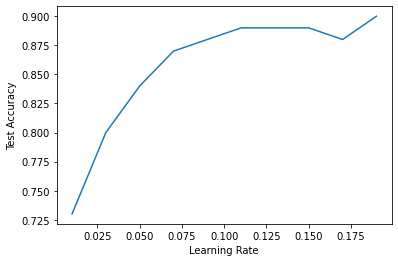

In [4]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(0.01,0.2,0.02)
y = np.array([0.73,0.80,0.84,0.87, 0.88, 0.89, 0.89,0.89, 0.88, 0.90])
fig = plt.figure()
ax = plt.axes()
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
ax.plot(x, y)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from LRFinder import LR_Finder
Loss="CrossEntropyLoss"
EPOCHS = 1
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
lrfinder = LR_Finder(optimizer)
optimizer, scheduler = lrfinder.range_test(start_lr=None, end_lr=3,num_iter=len(trainloader)*EPOCHS, step_mode="linear", smooth_f=0.05, diverge_th=5)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
model.gotrain(optimizer=optimizer, train_loader=trainset, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S11_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=lrfinder, L1lambda=0, LossType=Loss)

Batch=14 Loss=2.9653 Acc=10.45%:  19%|█▉        | 13/69 [00:57<04:07,  4.42s/it]

Stopping early, the loss has diverged


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
print(lrfinder.best_learn)

NameError: ignored

0.030622142857142855


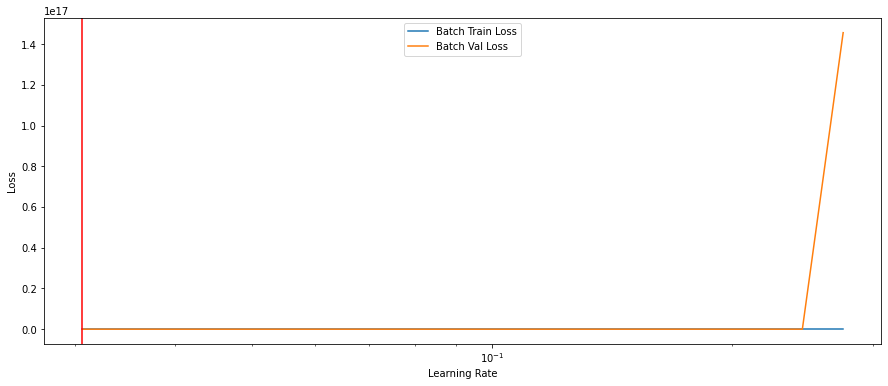

In [ ]:
print(lrfinder.best_learn)
lrfinder.plot(load_path=S11_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_train_loss", "batch_val_loss"], ylabel='Loss', legend_arr=['Batch Train Loss', 'Batch Val Loss'], title='Complete_LR_Finder_Curve', save_path=S11_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=0, log_lr=True, show_lr=lrfinder.best_learn)

Best LR Rate - 0.030622142857142855


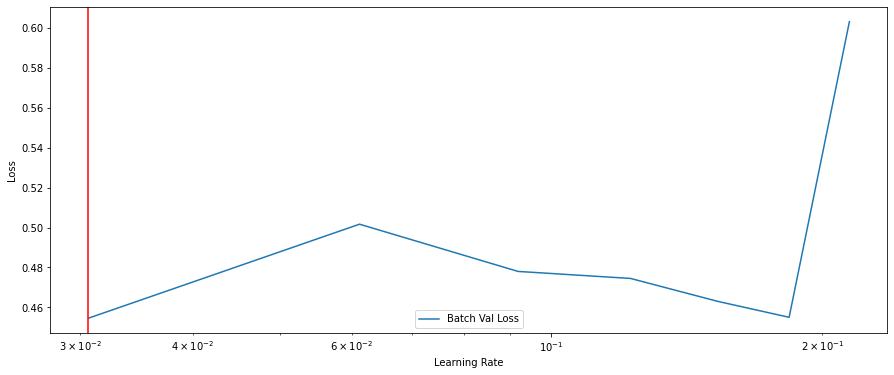

In [ ]:
print('Best LR Rate -', lrfinder.best_learn)
lrfinder.plot(load_path=S11_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_val_loss"], ylabel='Loss', legend_arr=['Batch Val Loss'], title='LR_Finder_Curve', save_path=S11_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=2, log_lr=True, show_lr=lrfinder.best_learn)

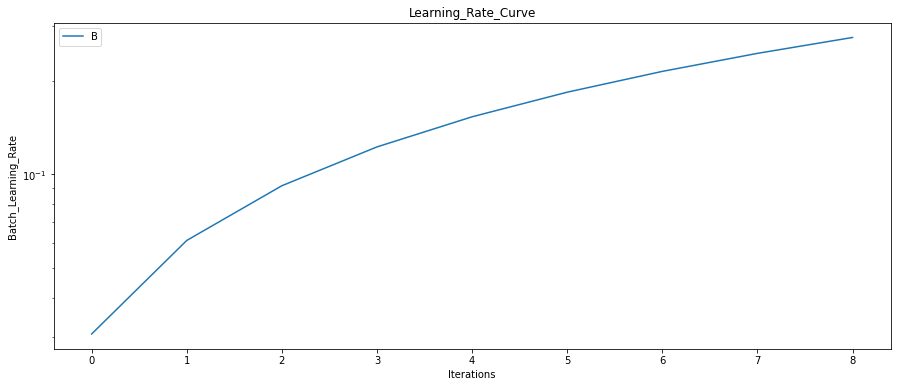

In [ ]:
plot_graph(load_path=S11_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json', cols=["batch_lr"], legend_arr='Batch_Learning_Curve', xlabel='Iterations', ylabel='Batch_Learning_Rate', title='Learning_Rate_Curve', save_path=S11_PROJECT_PATH+'/Save_Model/',log=True)

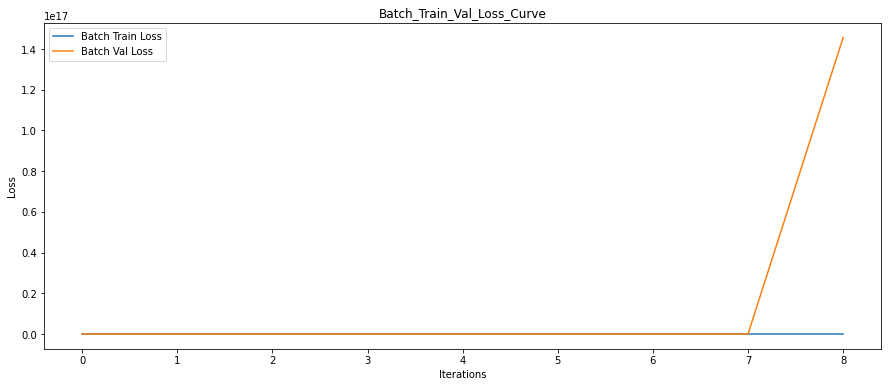

In [ ]:
plot_graph(load_path=S11_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json', cols=["batch_train_loss", "batch_val_loss"], legend_arr=['Batch Train Loss', 'Batch Val Loss'], xlabel='Iterations', ylabel='Loss', title='Batch_Train_Val_Loss_Curve', save_path=S11_PROJECT_PATH+'/Save_Model/')

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = Resnet_Custom_Architecture(name="Model_Res")
model.to(dataloader.device)
Loss="CrossEntropyLoss"
EPOCHS = 24
model.device=dataloader.device
optimizer = optim.SGD(model.parameters(), lr=lrfinder.best_learn, weight_decay=0.0019 ,momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
#scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lrfinder.best_learn, steps_per_epoch=len(trainloader), epochs=EPOCHS,  pct_start=5/EPOCHS, div_factor=10, final_div_factor=1, anneal_strategy='linear' )
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S11_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=True, L1lambda=0, LossType=Loss)

Batch=98 Loss=1.3927 Acc=41.10%: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]


Validation loss decreased (100000.000000 --> 0.026640).  Saving model ...


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1, Train set: Average loss: 0.0033, Accuracy: 41.10%; Test set: Average loss: 0.0266, Accuracy: 55.32%
Learning Rate = 0.008585


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.026640 --> 0.024194).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0021, Accuracy: 61.76%; Test set: Average loss: 0.0242, Accuracy: 63.15%
Learning Rate = 0.014109


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.024194 --> 0.018180).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0018, Accuracy: 69.18%; Test set: Average loss: 0.0182, Accuracy: 71.09%
Learning Rate = 0.019632


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.018180 --> 0.015691).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0014, Accuracy: 75.38%; Test set: Average loss: 0.0157, Accuracy: 76.08%
Learning Rate = 0.025155


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.015691 --> 0.013950).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0013, Accuracy: 77.79%; Test set: Average loss: 0.0139, Accuracy: 78.86%
Learning Rate = 0.030607


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6, Train set: Average loss: 0.0010, Accuracy: 82.09%; Test set: Average loss: 0.0194, Accuracy: 71.53%
Learning Rate = 0.029157


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.013950 --> 0.013948).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0009, Accuracy: 83.87%; Test set: Average loss: 0.0139, Accuracy: 79.22%
Learning Rate = 0.027706


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.013948 --> 0.010241).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0008, Accuracy: 85.53%; Test set: Average loss: 0.0102, Accuracy: 83.86%
Learning Rate = 0.026256


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.010241 --> 0.008689).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0007, Accuracy: 87.58%; Test set: Average loss: 0.0087, Accuracy: 85.42%
Learning Rate = 0.024805


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10, Train set: Average loss: 0.0006, Accuracy: 89.18%; Test set: Average loss: 0.0098, Accuracy: 84.82%
Learning Rate = 0.023355


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11, Train set: Average loss: 0.0006, Accuracy: 90.24%; Test set: Average loss: 0.0087, Accuracy: 86.52%
Learning Rate = 0.021904


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.008689 --> 0.008669).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0005, Accuracy: 90.64%; Test set: Average loss: 0.0087, Accuracy: 86.36%
Learning Rate = 0.020454


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13, Train set: Average loss: 0.0005, Accuracy: 91.54%; Test set: Average loss: 0.0088, Accuracy: 86.58%
Learning Rate = 0.019003


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14, Train set: Average loss: 0.0004, Accuracy: 92.68%; Test set: Average loss: 0.0103, Accuracy: 84.50%
Learning Rate = 0.017553


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 93.21%; Test set: Average loss: 0.0093, Accuracy: 86.21%
Learning Rate = 0.016102


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 93.81%; Test set: Average loss: 0.0092, Accuracy: 86.74%
Learning Rate = 0.014652


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.008669 --> 0.006883).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0003, Accuracy: 94.42%; Test set: Average loss: 0.0069, Accuracy: 89.25%
Learning Rate = 0.013201


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18, Train set: Average loss: 0.0003, Accuracy: 94.99%; Test set: Average loss: 0.0072, Accuracy: 89.07%
Learning Rate = 0.011751


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.006883 --> 0.006679).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0003, Accuracy: 95.64%; Test set: Average loss: 0.0067, Accuracy: 89.87%
Learning Rate = 0.010300


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 20, Train set: Average loss: 0.0002, Accuracy: 96.11%; Test set: Average loss: 0.0071, Accuracy: 89.57%
Learning Rate = 0.008850


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.006679 --> 0.006358).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0002, Accuracy: 96.53%; Test set: Average loss: 0.0064, Accuracy: 90.46%
Learning Rate = 0.007399


  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 22, Train set: Average loss: 0.0002, Accuracy: 96.87%; Test set: Average loss: 0.0065, Accuracy: 90.43%
Learning Rate = 0.005948


  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss decreased (0.006358 --> 0.006200).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0001, Accuracy: 97.60%; Test set: Average loss: 0.0062, Accuracy: 90.66%
Learning Rate = 0.004498


Batch=2352 Loss=0.0822 Acc=98.05%: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]


Validation loss decreased (0.006200 --> 0.005527).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0001, Accuracy: 98.05%; Test set: Average loss: 0.0055, Accuracy: 91.60%
Learning Rate = 0.003047



In [ ]:
#model.device=dataloader.device
#model = model_builder(model_class=Resnet_Architecture, weights_path=S11_PROJECT_PATH+'/Save_Model/Model.pt', local_device=model.device)

In [ ]:
class_acurracy(model, model.device, trainloader, classes)

Accuracy of plane : 97 %
Accuracy of   car : 99 %
Accuracy of  bird : 99 %
Accuracy of   cat : 95 %
Accuracy of  deer : 98 %
Accuracy of   dog : 95 %
Accuracy of  frog : 99 %
Accuracy of horse : 97 %
Accuracy of  ship : 99 %
Accuracy of truck : 98 %


In [ ]:
MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Miss')

In [ ]:
CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels = get_classified_images(model, model.device, testloader, classification='Corr')

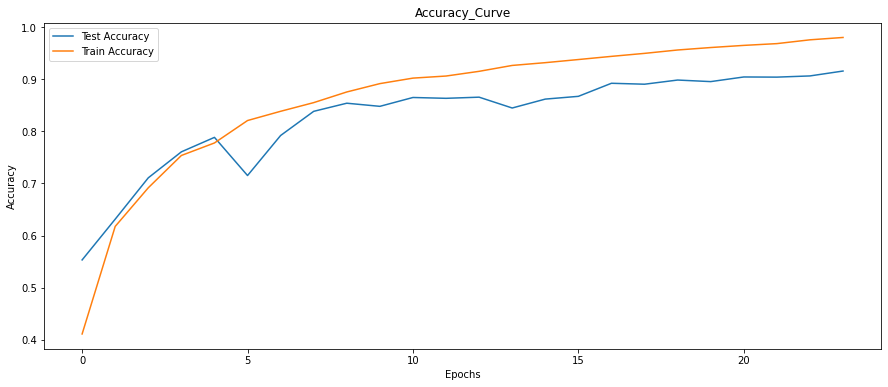

In [ ]:
#cols = ["batch_train_loss", "batch_train_acc", "batch_lr","avg_test_loss", "test_acc", "train_acc", "avg_train_loss", "lr", "best_test_loss", "epochs"]
plot_graph(load_path=S11_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["test_acc", "train_acc"], legend_arr=['Test Accuracy', 'Train Accuracy'], xlabel='Epochs', ylabel='Accuracy', title='Accuracy_Curve', save_path=S11_PROJECT_PATH+'/Save_Model/')

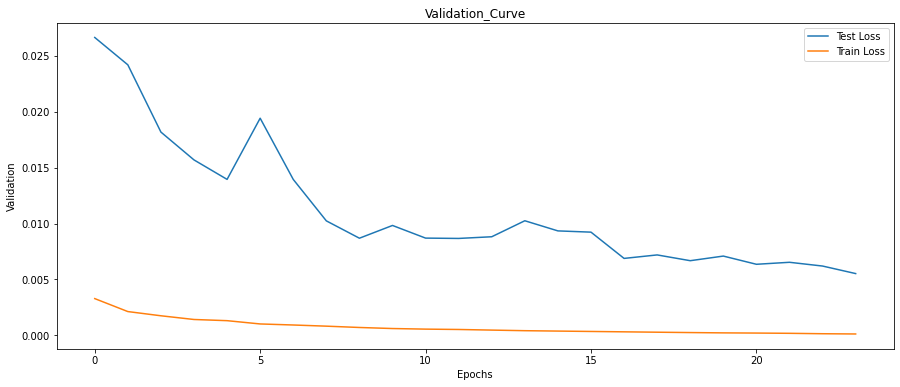

In [ ]:
plot_graph(load_path=S11_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["avg_test_loss","avg_train_loss"], legend_arr=['Test Loss', 'Train Loss'], xlabel='Epochs', ylabel='Validation', title='Validation_Curve', save_path=S11_PROJECT_PATH+'/Save_Model/')

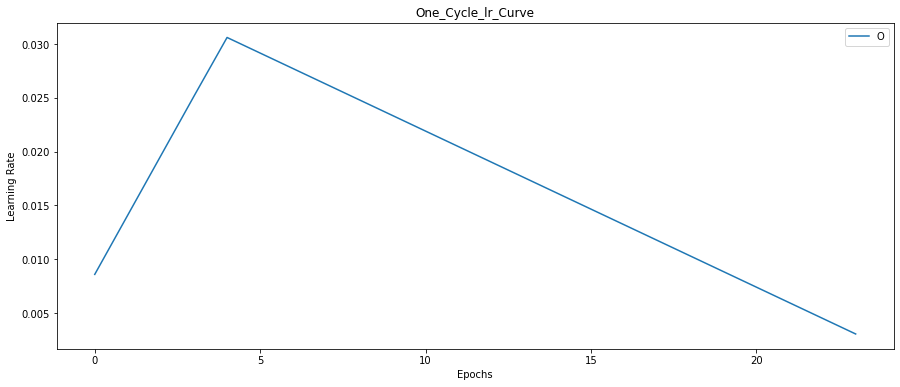

In [ ]:
plot_graph(load_path=S11_PROJECT_PATH+'/Save_Model/Model_Res_stats.json', cols=["lr"], legend_arr="One-Cycle Learning Rate", xlabel='Epochs', ylabel='Learning Rate', title='One_Cycle_lr_Curve', save_path=S11_PROJECT_PATH+'/Save_Model/')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


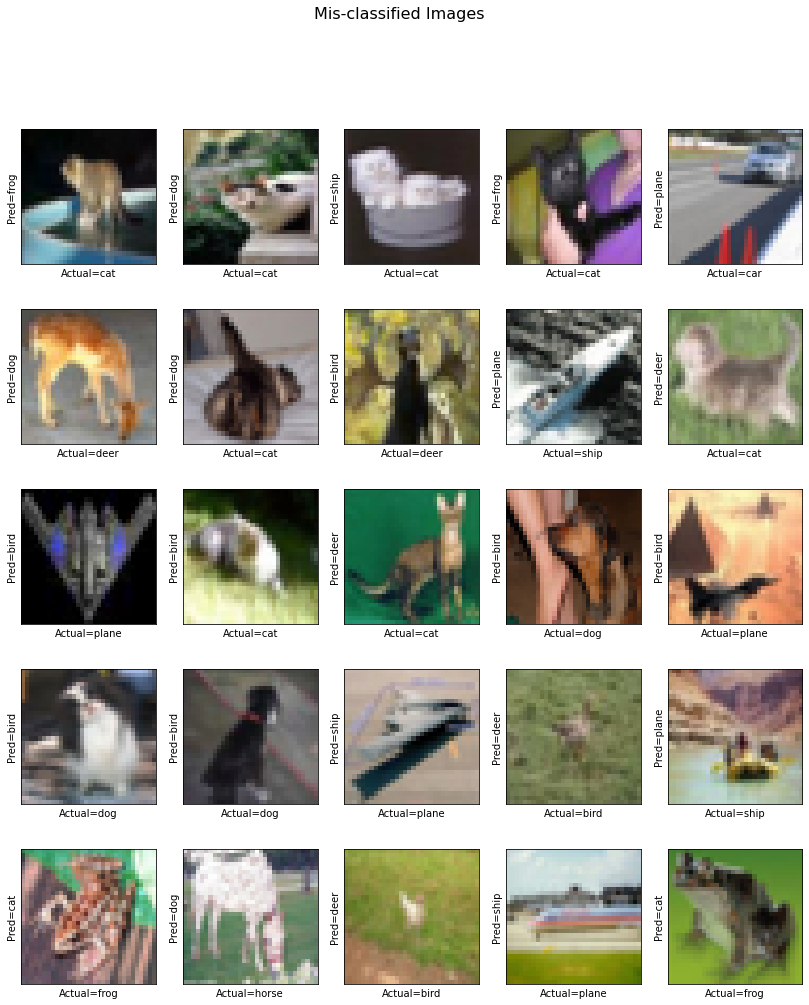

In [ ]:
show_classified(MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels, classes, mean, std,"Mis-classified Images",S11_PROJECT_PATH+'/Save_Model/',25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


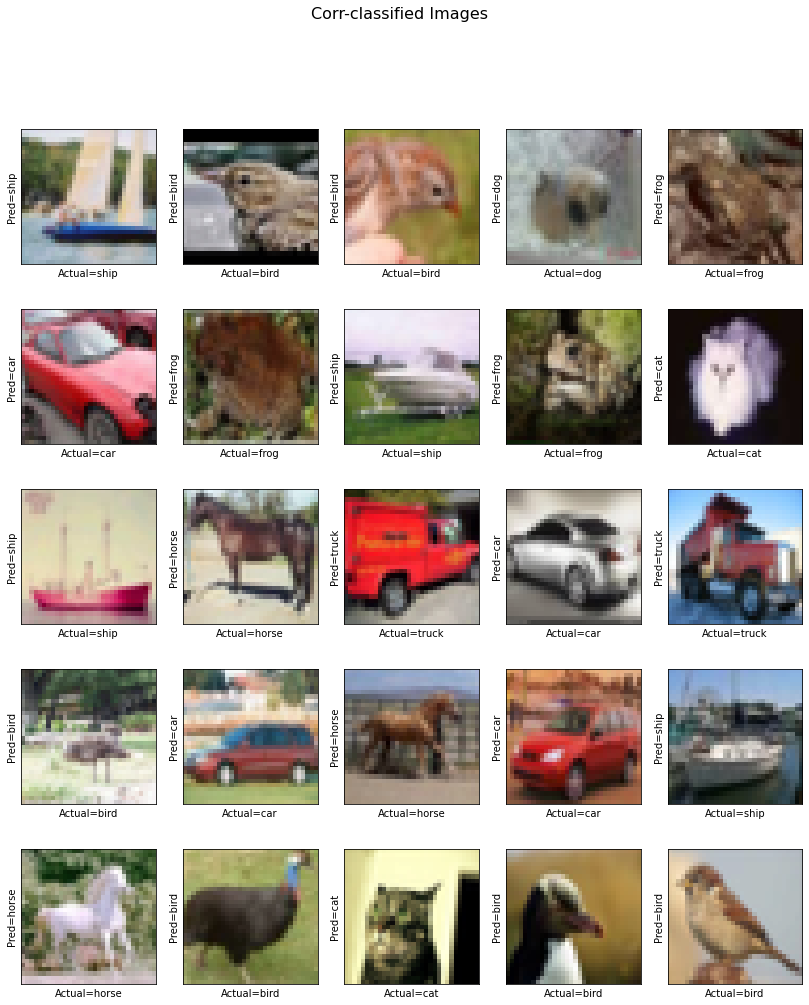

In [ ]:
show_classified(CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels, classes, mean, std,"Corr-classified Images",S11_PROJECT_PATH+'/Save_Model/',25)

In [ ]:
from GradCam import VisualizeCam

In [ ]:
target_layers = ["layer0", "layer1", "layer2", "layer3"]
viz_cam = VisualizeCam(model, classes, target_layers)

torch.Size([25, 10])
Generating Grad-CAM @layer0
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


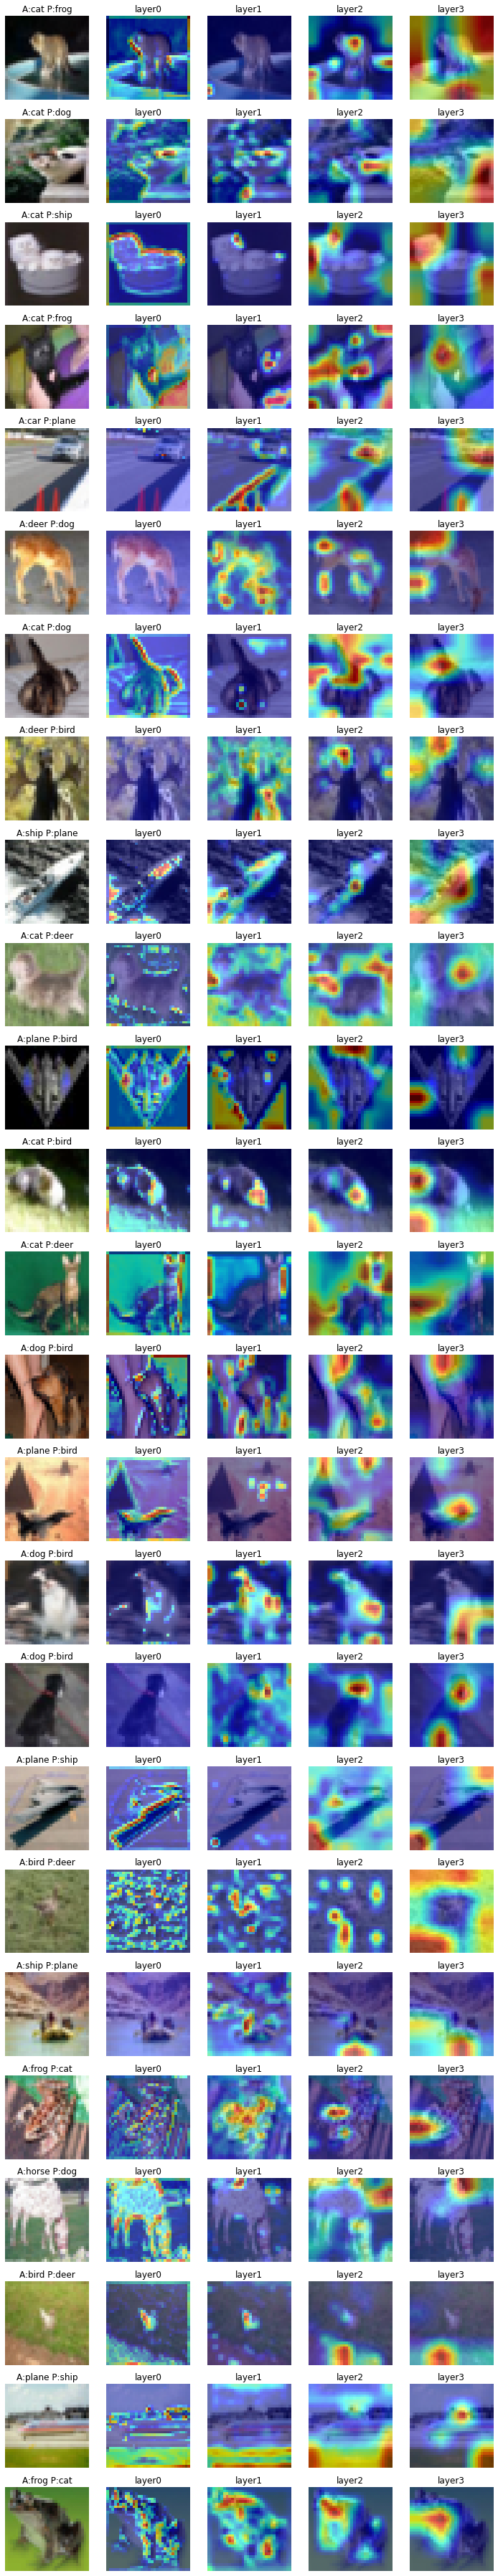

In [ ]:
viz_cam(MisClassifiedImages[:25], MisClassifiedTargLabels[:25], target_layers, mean, std, target_inds=MisClassifiedTargLabels[:25], metric="Incorrect", per_image=False, path=S11_PROJECT_PATH+"/Save_Model/")

torch.Size([25, 10])
Generating Grad-CAM @layer0
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

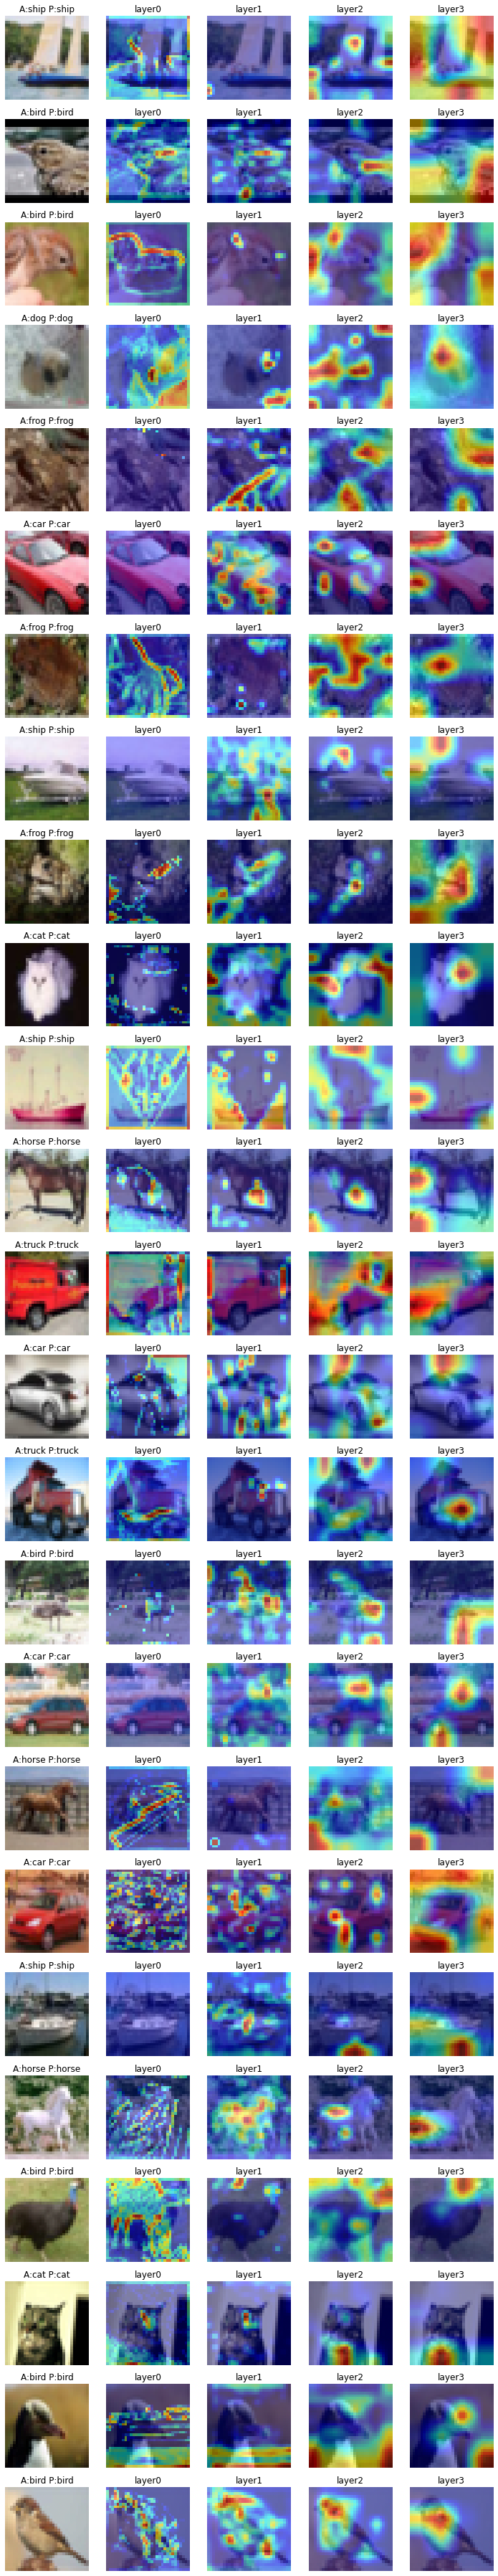

In [ ]:
viz_cam(CorrClassifiedImages[:25], CorrClassifiedTargLabels[:25], target_layers, mean, std, target_inds=None, metric="Correct", per_image=False, path=S11_PROJECT_PATH+"/Save_Model/")

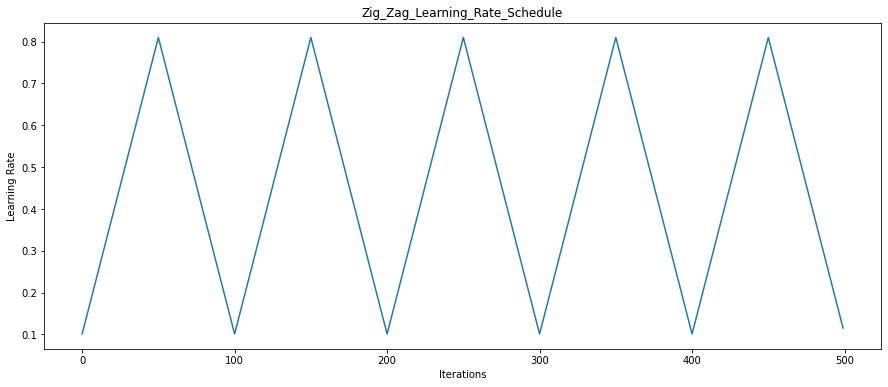

In [ ]:
# Zig-Zag Plot
from math import floor
import matplotlib.pyplot as plt
iterations = 500
lr_max = 0.81
lr_min = lr_max / 8
step_size = 50
cycle_size = step_size * 2
lrrrr = []
for curr_iter in range(iterations):
  cycle = floor(1 + curr_iter/cycle_size)
  x = abs(curr_iter/step_size - (2 * cycle) + 1)
  lr_t = lr_min + (lr_max - lr_min)*(1 - x)
  lrrrr.append(lr_t)
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(lrrrr)
ax.set(xlabel='Iterations', ylabel='Learning Rate')
plt.title('Zig_Zag_Learning_Rate_Schedule')
plt.show()
fig.savefig(S11_PROJECT_PATH+"/Save_Model/Zig_Zag_Learning.jpg")